# 🎓 TP Étudiant : Data Preprocessing (Nettoyage de Données)
**Cours : Data Management - Course 6**

--- 

## 🎯 Objectifs
Dans ce TP, vous allez mettre en pratique les techniques de nettoyage vues en cours :
1.  **Outlier Detection** : Identifier et supprimer les anomalies.
2.  **Missing Data** : Remplacer les valeurs manquantes.
3.  **Feature Selection** : Choisir les variables les plus pertinentes pour un modèle.

Les cellules contiennent des commentaires `# --- À COMPLÉTER ---` là où vous devez écrire votre code.

## 🛠️ Étape 0 : Préparation
Exécutez cette cellule pour importer les librairies nécessaires.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Outils Scikit-Learn (Documentation : https://scikit-learn.org/stable/)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification

sns.set_theme(style="whitegrid")
print("Environnement chargé !")

Environnement chargé !


--- 
## 1️⃣ Partie 1 : Détection d'Outliers (Anomalies)

### 1.1 Génération des données (Ne pas modifier)
Nous créons un jeu de données contenant une distribution normale et quelques valeurs extrêmes (outliers).

Taille du dataset : 1020


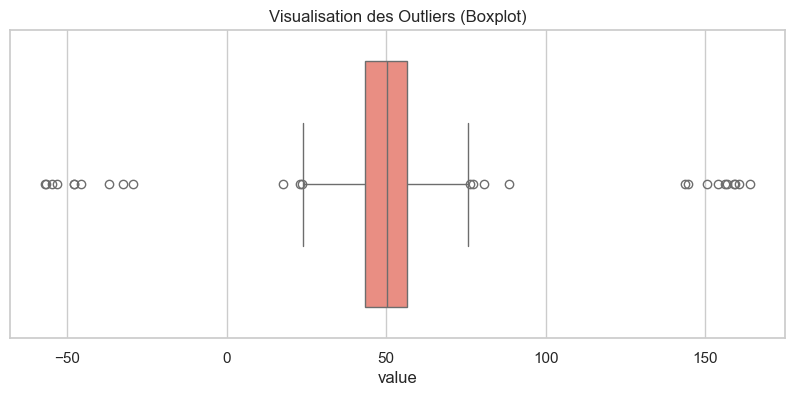

In [2]:
# Génération de 1000 points normaux
np.random.seed(42)
data_normal = np.random.normal(loc=50, scale=10, size=1000)

# Ajout de 20 outliers (très grands ou très petits)
data_outliers = np.random.normal(loc=150, scale=10, size=10)
data_outliers_low = np.random.normal(loc=-50, scale=10, size=10)

# Combinaison dans un DataFrame
data = np.concatenate([data_normal, data_outliers, data_outliers_low])
df_outliers = pd.DataFrame(data, columns=['value'])

print(f"Taille du dataset : {len(df_outliers)}")

# Visualisation
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_outliers['value'], color='salmon')
plt.title("Visualisation des Outliers (Boxplot)")
plt.show()

### 1.2 Exercice : Méthode Z-Score
La méthode Z-Score considère comme outlier tout point situé à plus de **3 écarts-types** de la moyenne.

**Votre mission :**
1. Calculez la moyenne (`mean`) et l'écart-type (`std`) de la colonne `value`.
2. Calculez le Z-Score pour chaque ligne : $Z = \frac{X - \mu}{\sigma}$
3. Créez un nouveau DataFrame `df_clean_z` en ne gardant que les lignes où $|Z| \le 3$.

In [3]:
# 1. Calcul des statistiques (Moyenne et Écart-type)
mean = df_outliers['value'].mean() 
std = df_outliers['value'].std()

# 2. Calcul du Z-Score
df_outliers['z_score'] = (df_outliers['value'] - mean) / std

# 3. Filtrage : Gardez uniquement les lignes où la valeur absolue du z_score est <= 3
df_clean_z = df_outliers[abs(df_outliers['z_score']) <= 3]

# Vérification
print(f"Données restantes après Z-Score : {len(df_clean_z)} (sur {len(df_outliers)})")
print(f"Outliers détectés : {len(df_outliers) - len(df_clean_z)}")

Données restantes après Z-Score : 1000 (sur 1020)
Outliers détectés : 20


### 1.3 Exercice : Méthode IQR (Interquartile Range)
Cette méthode utilise les quartiles et est plus robuste aux valeurs extrêmes.

**Votre mission :**
1. Calculez le 1er quartile (Q1, 25%) et le 3ème quartile (Q3, 75%).
2. Calculez l'écart interquartile : $IQR = Q3 - Q1$.
3. Définissez les bornes : 
   - `Borne Inf = Q1 - 1.5 * IQR`
   - `Borne Sup = Q3 + 1.5 * IQR`
4. Filtrez le DataFrame.

In [4]:
# 1. Calcul des Quartiles Q1 et Q3
Q1 = df_outliers['value'].quantile(0.25)
Q3 = df_outliers['value'].quantile(0.75)

# 2. Calcul de l'IQR
IQR = Q3 - Q1

# 3. Calcul des bornes (Lower & Upper bounds)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Filtrage : Gardez les valeurs comprises ENTRE les bornes
df_clean_iqr = df_outliers[(df_outliers['value'] >= lower_bound) & (df_outliers['value'] <= upper_bound)]
print(f"Données restantes après IQR : {len(df_clean_iqr)}")

Données restantes après IQR : 993


--- 
## 2️⃣ Partie 2 : Imputation des Données Manquantes

### 2.1 Chargement du dataset à trous (Ne pas modifier)

In [5]:
data_missing = {
    'Age': [25, 30, np.nan, 45, 22, np.nan, 35, 60],
    'Salary': [50000, 60000, 55000, np.nan, 45000, 52000, 70000, np.nan],
    'Department': ['HR', 'IT', 'IT', 'Finance', np.nan, 'HR', 'IT', 'Finance']
}
df_missing = pd.DataFrame(data_missing)

print("--- Dataset Original avec NaNs ---")
display(df_missing)
print("\n--- Comptage des manquants ---")
print(df_missing.isnull().sum())

--- Dataset Original avec NaNs ---


,Age,Salary,Department
0,25.0,50000.0,HR
1,30.0,60000.0,IT
2,NaN,55000.0,IT
3,45.0,NaN,Finance
4,22.0,45000.0,NaN
5,NaN,52000.0,HR
6,35.0,70000.0,IT
7,60.0,NaN,Finance



--- Comptage des manquants ---
Age           2
Salary        2
Department    1
dtype: int64


### 2.2 Exercice : 3 Stratégies d'Imputation

**Votre mission :**
1. **Suppression** : Créez `df_dropped` en supprimant toutes les lignes avec des NaNs.
2. **Moyenne** : Remplissez les NaNs de la colonne `Age` avec la moyenne des âges.
3. **Valeur Fixe** : Remplissez les NaNs de la colonne `Department` par la chaîne de caractères "Unknown".

In [6]:
# Stratégie 1 : Suppression (Listwise deletion)
df_dropped = df_missing.dropna()
print("1. Taille après suppression :", len(df_dropped))

# Création d'une copie pour l'imputation
df_imputed = df_missing.copy()

# Stratégie 2 : Remplacer Age par la moyenne
mean_age = df_imputed['Age'].mean()
df_imputed['Age'] = df_imputed['Age'].fillna(mean_age)

# Stratégie 3 : Remplacer Department par 'Unknown'
df_imputed['Department'] = df_imputed['Department'].fillna('Unknown')

print("\n--- Dataset Imputé ---")
display(df_imputed)

1. Taille après suppression : 3

--- Dataset Imputé ---


,Age,Salary,Department
0,25.000000,50000.0,HR
1,30.000000,60000.0,IT
2,36.166667,55000.0,IT
3,45.000000,NaN,Finance
4,22.000000,45000.0,Unknown
5,36.166667,52000.0,HR
6,35.000000,70000.0,IT
7,60.000000,NaN,Finance


--- 
## 3️⃣ Partie 3 : Feature Selection

Nous allons utiliser un dataset généré artificiellement contenant **20 variables**, mais dont **seules 3 sont utiles** pour prédire la cible (Target). Les autres sont du bruit.

### 3.1 Génération (Ne pas modifier)

In [7]:
X, y = make_classification(
    n_samples=500, 
    n_features=20, 
    n_informative=3, # Seules 3 variables portent l'information
    n_redundant=10,  
    n_classes=2, 
    random_state=42
)

df_features = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(20)])
df_features['Target'] = y

print("Dataset généré : 20 features, 1 target")

Dataset généré : 20 features, 1 target


### 3.2 Exercice : Matrice de Corrélation
Affichez la matrice de corrélation (Heatmap) pour essayer de repérer visuellement les relations.

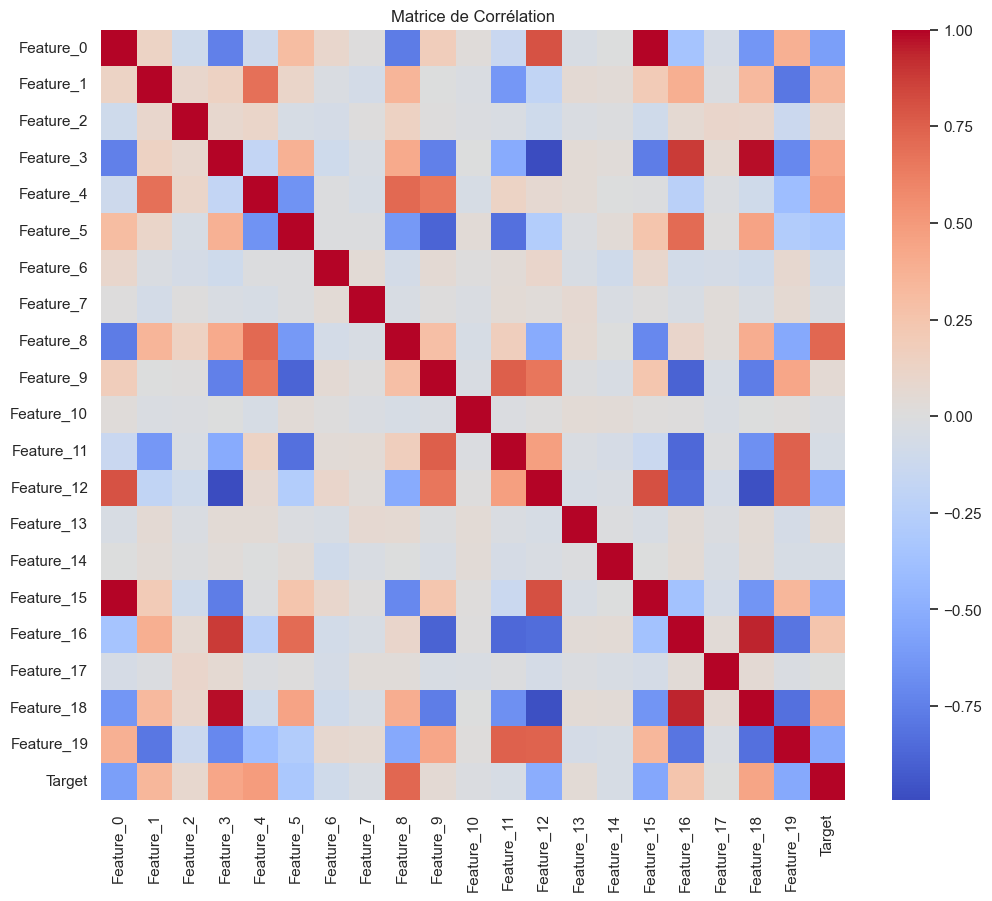

In [8]:
plt.figure(figsize=(12, 10))

# --- À COMPLÉTER ---
# 1. Calculez la matrice de corrélation
corr_matrix = df_features.corr()

# 2. Affichez la heatmap avec seaborn
sns.heatmap(corr_matrix, cmap='coolwarm')

plt.title("Matrice de Corrélation")
plt.show()

### 3.3 Exercice : SelectKBest
Il est difficile de choisir les variables à l'œil nu. Utilisons l'algorithme `SelectKBest`.

**Votre mission :**
1. Initialisez `SelectKBest` pour garder les **5 meilleures** variables (`k=5`). Utilisez la fonction de score `f_classif` (ANOVA).
2. Appliquez le sélecteur sur `X_data` et `y_data` (`fit`).
3. Affichez les noms des colonnes sélectionnées.

In [9]:
# Préparation des données (X = Features, y = Target)
X_data = df_features.drop('Target', axis=1)
y_data = df_features['Target']

# 1. Initialisation du sélecteur (garder k=5 variables)
selector = SelectKBest(score_func=f_classif, k=5)

# 2. Entraînement (Fit) sur les données
selector.fit(X_data, y_data)

# 3. Récupération des variables choisies
# Astuce : utilisez selector.get_support(indices=True)
selected_indices = selector.get_support(indices=True)
selected_features = X_data.columns[selected_indices]

print(f"Variables sélectionnées par l'algorithme : {list(selected_features)}")

Variables sélectionnées par l'algorithme : ['Feature_0', 'Feature_8', 'Feature_12', 'Feature_15', 'Feature_19']


## 🏁 Fin du TP
Si vous avez terminé, vérifiez que votre `SelectKBest` a bien trouvé les variables informatives (généralement Feature_0, Feature_1 etc, selon la graine aléatoire) et rejeté le bruit.